# Project 5 : Predict markets stocks of Google, Facebook & Amazon.

## MAP670G - Data Stream (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

__PART 1: DATA PROCESSING AND BATCH MACHINE LEARNING__

<br>
<img src="Google_Facebook_Amazon.PNG" width="600" height="600">
<br>

__Project 5 : Collect trading data using Yahoo finance API and use online regression to predict markets stocks of Google, Facebook & Amazon.__

__Option 2 :__ For each of these 5 countries, use 1 major industry stock data
For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.
This option was initially given in the project.

For each option, each group should use at least 3 different data streams, with online and adaptive regression on RIVER (such as https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/) and compare the performances with batch regression model (scikit-learn).

__ToDo:__ Compare online Regression vs Batch Regression and discuss the performance.

__Bonus :__ Use recent stock market data (from January to March 2022).

__Online resources:__ 
You can use the Python library to collect Yahoo Finance data in streaming https://pypi.org/project/yfinance/
You can compute time-series statistics and moving averages (MACD) for features engineering https://www.statsmodels.org/stable/tsa.html


In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [39]:
!pip3 install --quiet -r requirements.txt

In [40]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import kafka
from kafka.admin import KafkaAdminClient, NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
print("kafka version : {}". format(kafka.__version__))

import yfinance as yf
print("yfinance version : {}". format(yf.__version__))

import statsmodels
print("statsmodels version : {}". format(statsmodels.__version__))
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
print("scikit-learn version : {}". format(sklearn.__version__))

import river
from river import base
from river import drift
from river import datasets
from river import anomaly
from river.anomaly.hst import HalfSpaceTrees, make_padded_tree
from river import compose
from river import metrics
from river import preprocessing

print("river version : {}". format(river.__version__))

import ipywidgets as widgets
print("ipywidgets version : {}". format(widgets.__version__))

import time
from time import perf_counter
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

from enum import Enum, auto

import math

import pprint

import json

import urllib.request

import warnings
warnings.filterwarnings('ignore')

print("====================================")

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
IPython version: 7.27.0
NumPy version: 1.20.3
SciPy version: 1.7.1
pandas version: 1.3.2
matplotlib version: 3.4.2
seaborn version : 0.11.2
kafka version : 2.0.2
yfinance version : 0.1.70
statsmodels version : 0.13.2
scikit-learn version : 1.0.1
river version : 0.9.0
ipywidgets version : 7.6.5


## Utility functions

In [41]:
def printmd(text, couleur=None):
    """
    Printing of the string text by choosing the style (for example bold) and the color (couleur)
    """
    colorstr = "<span style='color:{}'>{}</span>".format(couleur, text)
    display(Markdown(colorstr))

## Launching the servers
<p><b>LAUNCHING ZOOKEEPER AND KAFKA SERVER ON WINDOWS</b></p>
<p> In a <b>first terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
<p>  </p>
<p> In a <b>second terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\kafka-server-start.bat .\config\server.properties
<p>  -- </p>
<p>we assume that Zookeeper is running default on localhost:2181 and Kafka on localhost:9092.</p>

# Selection of data to be used (historical or recent data)

__HISTORICAL : Daily stock market data for the last 20 years__

__RECENT : Hourly stock market data from January 2021 to March 2022__

In [42]:
class Information(Enum):
    HISTORICAL = auto()
    RECENT = auto()

the_data_type = Information.RECENT

if the_data_type == Information.RECENT:
    print("Analysis of hourly stock market data from January 2021 to March 2022")
elif the_data_type == Information.HISTORICAL:
    print("Analysis of daily stock market data for the last 20 years")
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Analysis of hourly stock market data from January 2021 to March 2022


# Get stock market data from Google, Facebook, Amazon, Total, Gazprom, Alibaba, BNP-Paribas, BP and Ferrari

## stock market data identifiers

In [43]:
the_GAF = ["google", "amazon", "facebook"]
All_the_companies = ["google",
                     "facebook",
                     "amazon",
                     "total",
                     "gazprom",
                     "alibaba",
                     "bnp_paribas",
                     "BP",
                     "ferrari"]

tick = {}
tick["google"] = "GOOG"
tick["facebook"] = "FB"
tick["amazon"] = "AMZN"
tick["total"] = "TTE"
tick["gazprom"] = "OGZPY"
tick["alibaba"] = "BABA"
tick["bnp_paribas"] = "BNPQY"
tick["BP"] = "BP"
tick["ferrari"] = "RACE"

the_GAF_tickers = " ".join(map(str, [v for k, v in tick.items() if k in the_GAF]))
all_the_tickers = " ".join(map(str, [v for v in tick.values()]))
GAF_tick = yf.Tickers(the_GAF_tickers)
ALL_tick = yf.Tickers(all_the_tickers)

google = GAF_tick.tickers[tick["google"]]
facebook = GAF_tick.tickers[tick["facebook"]]
amazon = GAF_tick.tickers[tick["amazon"]]

total = yf.Ticker(tick["total"])
gazprom = yf.Ticker(tick["gazprom"])
alibaba = yf.Ticker(tick["alibaba"])
bnp_paribas = yf.Ticker(tick["bnp_paribas"])
BP = yf.Ticker(tick["BP"])
ferrari = yf.Ticker(tick["ferrari"])

## Get information on companies

In [44]:
google_info = google.info
facebook_info = facebook.info
amazon_info = amazon.info
total_info = total.info
gazprom_info = gazprom.info
alibaba_info = alibaba.info
bnp_paribas_info = bnp_paribas.info
BP_info = BP.info
ferrari_info = ferrari.info

stock_info = [google_info, facebook_info, amazon_info,
              total_info, gazprom_info, alibaba_info,
              bnp_paribas_info, BP_info, ferrari_info]

for i, info in enumerate(stock_info):
    print("---------- {} ----------".format(All_the_companies[i]))
    print("{} - sector: {}; country: {}; logo: {}" \
        .format(info["shortName"],
                info["sector"],
                info["country"],
                info["logo_url"]))
    print("")

---------- google ----------
Alphabet Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/abc.xyz

---------- facebook ----------
Meta Platforms, Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/investor.fb.com

---------- amazon ----------
Amazon.com, Inc. - sector: Consumer Cyclical; country: United States; logo: https://logo.clearbit.com/amazon.com

---------- total ----------
TotalEnergies SE - sector: Energy; country: France; logo: https://logo.clearbit.com/totalenergies.com

---------- gazprom ----------
GAZPROM PUBLIC JOINT STOCK COMP - sector: Energy; country: Russia; logo: https://logo.clearbit.com/gazprom.com

---------- alibaba ----------
Alibaba Group Holding Limited - sector: Consumer Cyclical; country: China; logo: https://logo.clearbit.com/alibabagroup.com

---------- bnp_paribas ----------
BNP PARIBAS ADR EACH REPR 1/2 O - sector: Financial Services; country: France; logo: https://l

## Set parameters for yfinance package

In [45]:
if the_data_type == Information.RECENT:
    deb = "2021-01-01"
    fin = "2022-03-31"
    interval = "1h"
    init_type = True
elif the_data_type == Information.HISTORICAL:
    deb = "2002-01-01"
    fin = "2022-03-31"
    interval = "1d"
    init_type = True
else:
    init_type = False
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

## Get stock market data

In [46]:
if init_type:
    print("Get stock market data (interval={}) from {} to {}.".format(interval, deb, fin))
    temps = perf_counter()
    data = yf.download(all_the_tickers, start=deb, end=fin, interval=interval, group_by='ticker')
    temps_recuperation_donnees = perf_counter() - temps
    print("CPU time = {:.3f} seconds".format(temps_recuperation_donnees))
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Get stock market data (interval=1h) from 2021-01-01 to 2022-03-31.
[*********************100%***********************]  9 of 9 completed
CPU time = 1.980 seconds


## Describe the stock market data collected

In [47]:
data

BNPQY                                   \
                                Open       High        Low      Close   
2021-01-04 09:30:00-05:00  26.594999  26.690001  26.180000  26.219999   
2021-01-04 10:30:00-05:00  26.148001  26.375000  26.145000  26.375000   
2021-01-04 11:30:00-05:00  26.340000  26.340000  26.059999  26.115000   
2021-01-04 12:30:00-05:00  26.129999  26.275000  26.110001  26.275000   
2021-01-04 13:30:00-05:00  26.230000  26.305000  26.230000  26.290001   
...                              ...        ...        ...        ...   
2022-03-31 10:41:20-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:29-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:39-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:40-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:41-04:00        NaN        NaN        NaN        NaN   

                                               OGZPY                     ...  \
                           Adj Close    Volume  Open  High   Low  Close  ...   
2021-01-04 09:30:00-05:00  26.219999       0.0  5.81  5.83  5.80  5.820  ...   
2021-01-04 10:30:00-05:00  26.375000   16875.0  5.81  5.81  5.73  5.730  ...   
2021-01-04 11:30:00-05:00  26.115000  134307.0  5.72  5.74  5.69  5.690  ...   
2021-01-04 12:30:00-05:00  26.275000    6955.0  5.67  5.72  5.66  5.720  ...   
2021-01-04 13:30:00-05:00  26.290001   13003.0  5.72  5.72  5.69  5.712  ...   
...                              ...       ...   ...   ...   ...    ...  ...   
2022-03-31 10:41:20-04:00        NaN       NaN   NaN   NaN   NaN    NaN  ...   
2022-03-31 10:41:29-04:00        NaN       NaN   NaN   NaN   NaN    NaN  ...   
2022-03-31 10:41:39-04:00        NaN       NaN   NaN   NaN   NaN    NaN  ...   
2022-03-31 10:41:40-04:00        NaN       NaN   NaN   NaN   NaN    NaN  ...   
2022-03-31 10:41:41-04:00        NaN       NaN   NaN   NaN   NaN    NaN  ...   

                                  BP                                   \
                                 Low      Close  Adj Close     Volume   
2021-01-04 09:30:00-05:00  20.760000  20.780001  20.780001  4089186.0   
2021-01-04 10:30:00-05:00  20.549999  20.709999  20.709999  3292589.0   
2021-01-04 11:30:00-05:00  20.600000  20.760000  20.760000  1966692.0   
2021-01-04 12:30:00-05:00  20.700001  20.934999  20.934999  1155757.0   
2021-01-04 13:30:00-05:00  20.820000  20.879999  20.879999  1291012.0   
...                              ...        ...        ...        ...   
2022-03-31 10:41:20-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:29-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:39-04:00        NaN        NaN        NaN        NaN   
2022-03-31 10:41:40-04:00  29.730000  29.730000  29.730000        0.0   
2022-03-31 10:41:41-04:00        NaN        NaN        NaN        NaN   

                                   FB                                      \
                                 Open        High         Low       Close   
2021-01-04 09:30:00-05:00  273.750000  273.899994  269.980011  271.170013   
2021-01-04 10:30:00-05:00  271.269989  272.637787  267.459991  268.320007   
2021-01-04 11:30:00-05:00  268.220001  269.049988  265.200012  266.940002   
2021-01-04 12:30:00-05:00  266.920013  269.040009  265.899994  268.446899   
2021-01-04 13:30:00-05:00  268.440002  269.779907  268.070007  269.279999   
...                               ...         ...         ...         ...   
2022-03-31 10:41:20-04:00         NaN         NaN         NaN         NaN   
2022-03-31 10:41:29-04:00         NaN         NaN         NaN         NaN   
2022-03-31 10:41:39-04:00         NaN         NaN         NaN         NaN   
2022-03-31 10:41:40-04:00         NaN         NaN         NaN         NaN   
2022-03-31 10:41:41-04:00  225.979996  225.979996  225.979996  225.979996   

                                                  
                            Adj Close

In [48]:
data.describe()

BNPQY                                                      \
              Open         High          Low        Close    Adj Close   
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean     31.591310    31.686386    31.503521    31.595895    31.595895   
std       2.736399     2.733267     2.745384     2.741883     2.741883   
min      24.000000    24.145000    24.000000    24.025000    24.025000   
25%      30.200001    30.320000    30.139999    30.230000    30.230000   
50%      31.690001    31.780001    31.629999    31.700001    31.700001   
75%      33.689999    33.830002    33.619999    33.740002    33.740002   
max      38.299999    38.410000    38.200001    38.299999    38.299999   

                           OGZPY                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  2.109000e+03  1987.000000  1987.000000  1987.000000  1987.000000  ...   
mean   4.226537e+04     7.658670     7.682958     7.635141     7.659200  ...   
std    1.535947e+05     1.553798     1.548355     1.557421     1.554188  ...   
min    0.000000e+00     1.100000     1.100000     1.100000     1.100000  ...   
25%    8.309000e+03     6.135000     6.150000     6.120000     6.140000  ...   
50%    1.592700e+04     7.670000     7.690000     7.650000     7.665000  ...   
75%    3.080500e+04     8.992500     9.019250     8.960000     8.990000  ...   
max    2.628363e+06    10.710000    10.720000    10.690000    10.720000  ...   

                BP                                                   FB  \
               Low        Close    Adj Close        Volume         Open   
count  2113.000000  2113.000000  2113.000000  2.113000e+03  2112.000000   
mean     26.456438    26.554477    26.554477  1.923262e+06   308.504059   
std       2.482219     2.485815     2.485815  1.506164e+06    47.726416   
min      20.424999    20.540001    20.540001  0.000000e+00   186.059998   
25%      24.719999    24.795000    24.795000  1.005434e+06   272.249992   
50%      26.290001    26.370001    26.370001  1.472885e+06   324.245010   
75%      27.760000    27.855000    27.855000  2.316888e+06   341.541252   
max      34.005001    34.035000    34.035000  1.823072e+07   383.559998   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  2112.000000  2112.000000  2112.000000  2112.000000  2.112000e+03  
mean    309.808557   307.156510   308.506625   308.506625  2.842954e+06  
std      47.643585    47.786832    47.719833    47.719833  3.271998e+06  
min     187.699997   185.820007   186.059998   186.059998  0.000000e+00  
25%     273.742508   271.297493   272.506256   272.506256  1.430665e+06  
50%     325.675003   322.809998   324.224991   324.224991  2.089627e+06  
75%     342.652275   340.502502   341.489853   341.489853  3.354201e+06  
max     384.329987   382.989990   383.600006   383.600006  7.980038e+07  

[8 rows x 54 columns]

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2125 entries, 2021-01-04 09:30:00-05:00 to 2022-03-31 10:41:41-04:00
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (BNPQY, Open)       2109 non-null   float64
 1   (BNPQY, High)       2109 non-null   float64
 2   (BNPQY, Low)        2109 non-null   float64
 3   (BNPQY, Close)      2109 non-null   float64
 4   (BNPQY, Adj Close)  2109 non-null   float64
 5   (BNPQY, Volume)     2109 non-null   float64
 6   (OGZPY, Open)       1987 non-null   float64
 7   (OGZPY, High)       1987 non-null   float64
 8   (OGZPY, Low)        1987 non-null   float64
 9   (OGZPY, Close)      1987 non-null   float64
 10  (OGZPY, Adj Close)  1987 non-null   float64
 11  (OGZPY, Volume)     1987 non-null   float64
 12  (BABA, Open)        2113 non-null   float64
 13  (BABA, High)        2113 non-null   float64
 14  (BABA, Low)         2113 non-null   float64
 15  (BABA, 

In [50]:
data.columns

MultiIndex([('BNPQY',      'Open'),
            ('BNPQY',      'High'),
            ('BNPQY',       'Low'),
            ('BNPQY',     'Close'),
            ('BNPQY', 'Adj Close'),
            ('BNPQY',    'Volume'),
            ('OGZPY',      'Open'),
            ('OGZPY',      'High'),
            ('OGZPY',       'Low'),
            ('OGZPY',     'Close'),
            ('OGZPY', 'Adj Close'),
            ('OGZPY',    'Volume'),
            ( 'BABA',      'Open'),
            ( 'BABA',      'High'),
            ( 'BABA',       'Low'),
            ( 'BABA',     'Close'),
            ( 'BABA', 'Adj Close'),
            ( 'BABA',    'Volume'),
            (  'TTE',      'Open'),
            (  'TTE',      'High'),
            (  'TTE',       'Low'),
            (  'TTE',     'Close'),
            (  'TTE', 'Adj Close'),
            (  'TTE',    'Volume'),
            ( 'AMZN',      'Open'),
            ( 'AMZN',      'High'),
            ( 'AMZN',       'Low'),
            ( 'AMZN',     'C

## Plot the Close price of the stock market data collected

In [51]:
def plot_closing(data, company_name, tick, short_window=20, long_window=100, unite="days"):
    the_data = data[(tick, "Close")]
    ax = the_data.plot(figsize=(15,8),
                       label="{}".format(tick),
                       title="Closing price (in USD) of the stock market for {}" \
                             .format(company_name))
    # Calculate the <short_window> and <long_window> moving averages of the closing prices
    if short_window is not None:
        short_rolling = the_data.rolling(window=short_window).mean()
        short_rolling.plot(label="{} {} rolling".format(short_window, unite))
    if long_window is not None:
        long_rolling = the_data.rolling(window=long_window).mean()
        long_rolling.plot(label="{} {} rolling".format(long_window, unite))
    ax.legend()
    plt.show()

In [52]:
# Set the windows for moving averages of the closing prices
if the_data_type == Information.RECENT:
    unite = "hours"
    short_window = 7                               # 7 hours = 1 day
    long_window = 35                               # 35 hours = 1 week
elif the_data_type == Information.HISTORICAL:
    unite = "days"
    short_window = 20                              # time in days
    long_window = 100                              # time in days
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

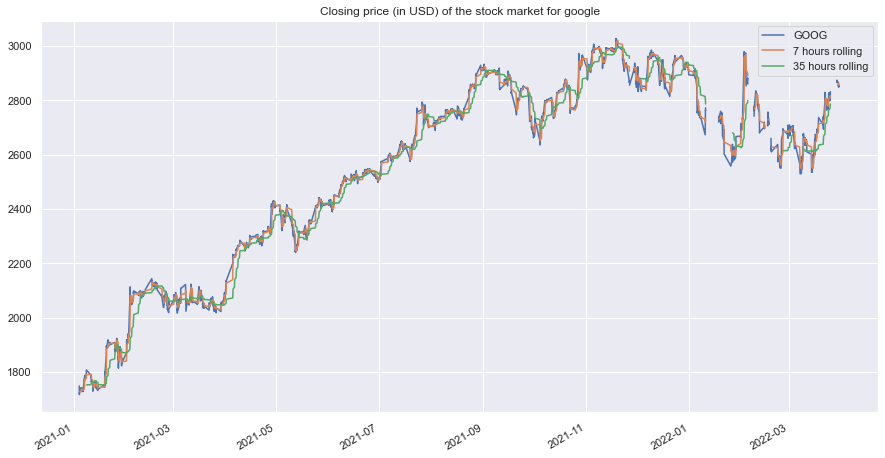

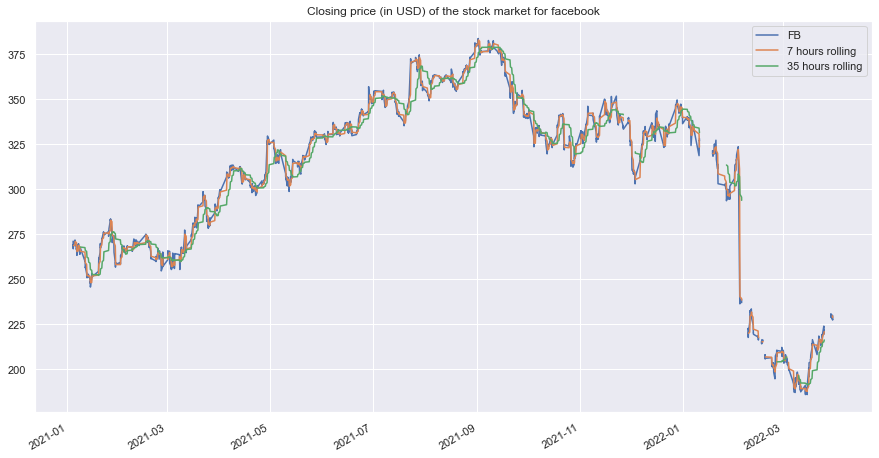

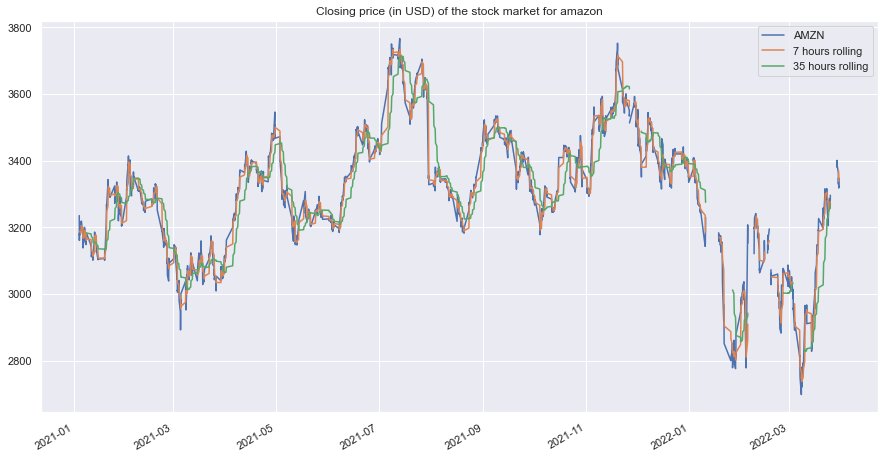

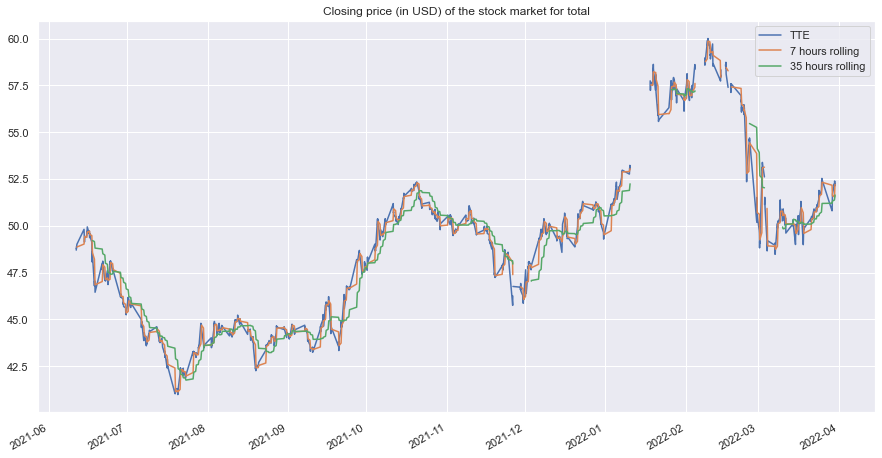

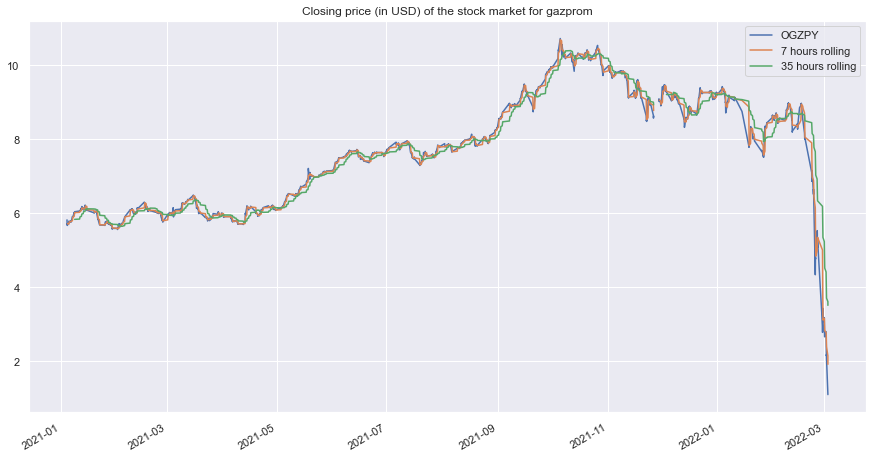

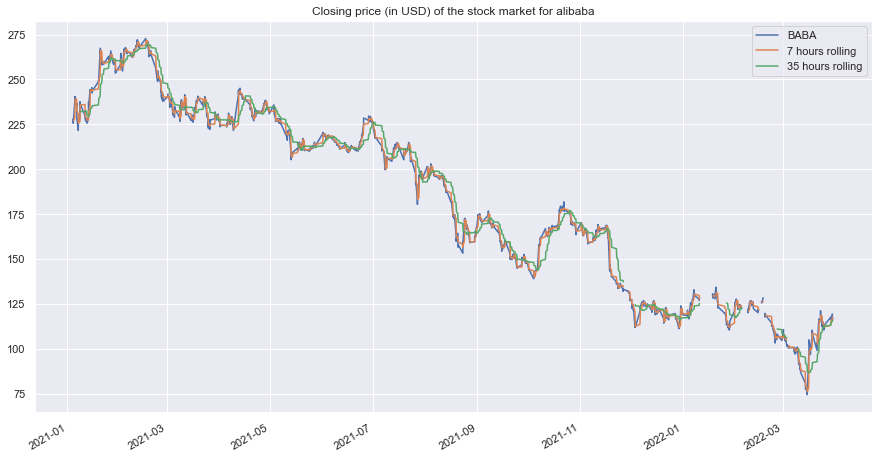

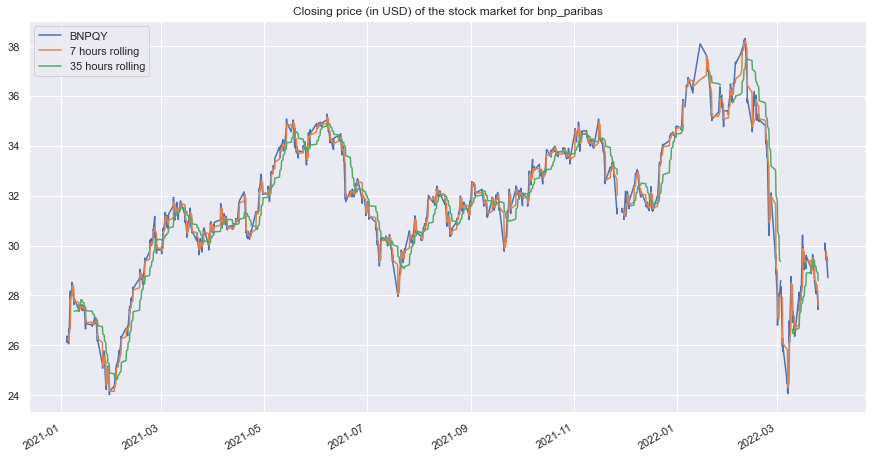

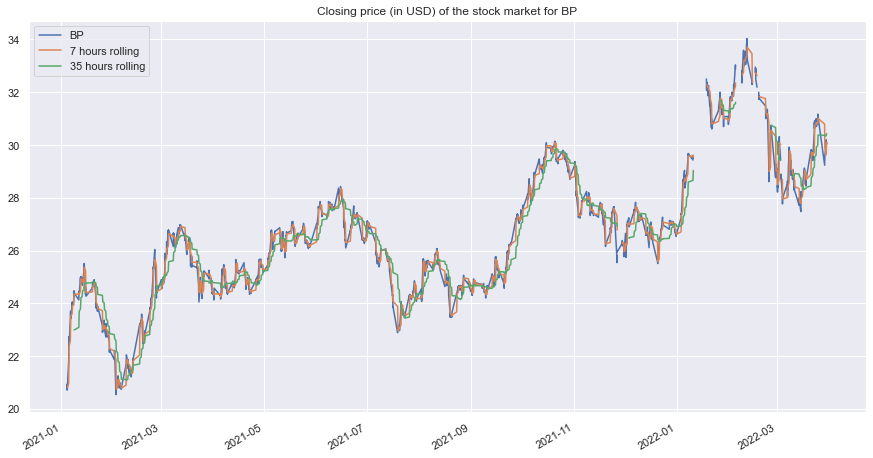

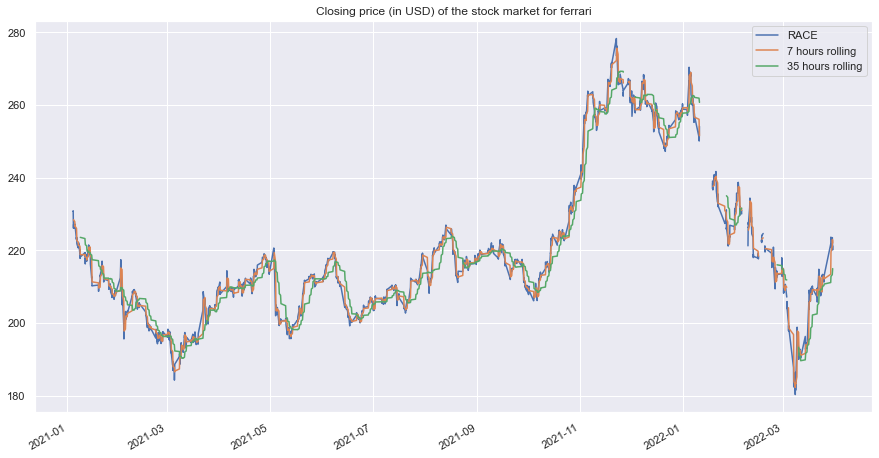

In [53]:
for company in All_the_companies:
    plot_closing(data,
                 company,
                 tick[company],
                 short_window=short_window,
                 long_window=long_window,
                 unite=unite)

# Stock market prediction using batch regression

## Initialize dictionaries to save data for the others Notebooks

In [54]:
# Initialize a Dictionary to save the number of samples for each company
Nb_stocks = {}
Nb_stocks["Company"] = []
Nb_stocks["shape"] = []

In [55]:
# Initialize a Dictionary to save the results
Batch_ML_result = {}
Batch_ML_result["CPU_time"] = []
Batch_ML_result["MAE"] = []
Batch_ML_result["date"] = []
Batch_ML_result["Regression"] = []
Batch_ML_result["Company"] = []

## Select the data to use for Machine Learning

In [56]:
data_clean = {}

for company in All_the_companies:
    Close_price_for_the_selected_company = data[(tick[company], "Close")]
    # Delete the NaN values
    data_clean[company] = Close_price_for_the_selected_company.dropna()
    Nb_stocks["Company"].append(company)
    Nb_stocks["shape"].append(data_clean[company].shape[0])

df_Nb_stocks = pd.DataFrame(Nb_stocks)
df_Nb_stocks.to_csv("Nb_stocks.csv", sep=";", decimal=",")
df_Nb_stocks

,Company,shape
0,google,2112
1,facebook,2112
2,amazon,2112
3,total,1343
4,gazprom,1987
5,alibaba,2113
6,bnp_paribas,2109
7,BP,2113
8,ferrari,2113


## Split the data between the train and test datasets.

In [57]:
if the_data_type == Information.RECENT:
    # test length = 3 weeks (21 days)
    neg_test_length = relativedelta(days=-21)
    # Recent data are collected every hour
    delta_train_test = timedelta(hours=1)
elif the_data_type == Information.HISTORICAL:
    # test length = 2 months
    neg_test_length = relativedelta(months=-2)
    # Historical data are collected every day
    delta_train_test = timedelta(days=1)
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

In [58]:
data_train = {}
data_test = {}

for company in All_the_companies:
    date_fin = data_clean[company].tail(1).index.to_list()[0]
    date_deb_test = date_fin + neg_test_length
    date_fin_train = date_deb_test - delta_train_test
    data_train[company] = data_clean[company][:date_fin_train]
    data_test[company] = data_clean[company][date_deb_test:]

In [59]:
No_Company = 0              # value from 0 to 8

The_selected_company = All_the_companies[No_Company]
print("test dataset for {}".format(The_selected_company))
data_test[The_selected_company]

test dataset for google


2022-03-10 10:30:00-05:00    2633.560059
2022-03-10 11:30:00-05:00    2640.300049
2022-03-10 12:30:00-05:00    2643.060059
2022-03-10 13:30:00-05:00    2662.030029
2022-03-10 14:30:00-05:00    2654.000000
                                ...     
2022-03-30 12:30:00-04:00    2857.389893
2022-03-30 13:30:00-04:00    2853.520020
2022-03-30 14:30:00-04:00    2848.479980
2022-03-30 15:30:00-04:00    2853.419922
2022-03-31 10:41:13-04:00    2826.760010
Name: (GOOG, Close), Length: 95, dtype: float64

## ARMA Model

In [60]:
def Modele_ARIMA(Serie, p, q, d = 0):
    """
    Input parameters : Time series and parameters p, d, q (default value of d is 0 : ARMA model)
    
    Return : Model trained on the time series data
    """
    
    # Model building from the Series data
    Modele = ARIMA(Serie, order=(p, d, q)).fit()
    
    # Model quality
    print(Modele.summary())
    
    # Extraction of residue
    Residu = Modele.resid
    
    # Statistical tests on the residue
    
    # 1 - White noise
    df_result = acorr_ljungbox(Residu, boxpierce=True)
    p_value_Box_Pierce = df_result["bp_pvalue"].iloc[0]
    
    # 2 - Normal distribution
    statistique, p_value_Shapiro = stats.shapiro(Residu)
    
    # 3 - Stationarity
    adf, p_value_ADF, usedlag, nobs, critical_values, icbest = adfuller(Residu)
    kpss_stat, p_value_KPSS, lags, crit = kpss(Residu)

    
    print("")
    print("\nBox-Pierce test: pvalue = {}".format(p_value_Box_Pierce))
    if (p_value_Box_Pierce > 0.05):
        print("The residual is a white noise because the hypothesis H0 is satisfied")
    else:
        print("The residual is not a white noise because the hypothesis H0 is not satisfied")
    
    print("\nShapiro-Wilk test: pvalue = {}".format(p_value_Shapiro))
    if (p_value_Shapiro > 0.05):
        print("The residual follows a Normal distribution because the hypothesis H0 is verified")
    else:
        print("The residual does not follow a Normal distribution because the hypothesis H0 is not verified")

    print("\nAugmented Dickey Fuller Test: pvalue = {}".format(p_value_ADF))
    if (p_value_ADF > 0.05):
        print("The residual is not a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is a stationary process because the hypothesis H0 is not verified")
        
    print("\nKwiatkowski-Phillips-Schmidt-Shin test: pvalue = {}".format(p_value_KPSS))
    if (p_value_KPSS > 0.05):
        print("The residual is a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is not a stationary process because the hypothesis H0 is not verified")
    
    return Modele

In [61]:
def Modele_Predict(Modele, Test):
    """
    Input data: Trained ARIMA model and time series Test
    
    Return: the prediction score and the dataframe with the values predicted by the model 
    """
    Valeurs_predites = Modele.get_forecast(len(Test))
    df_Prediction = Valeurs_predites.summary_frame()
    df_Prediction["date"] = Test.index.tolist()
    df_Prediction.set_index("date", inplace=True)
    df_Prediction.drop(["mean_se"], axis="columns", inplace=True)
    df_Prediction.rename(columns={"mean": "Prediction", 
                                  "mean_ci_lower": "Borne_Inf_95",
                                  "mean_ci_upper": "Borne_Sup_95"}, inplace=True)
    
    # Scores of the prediction
    MAE = mean_absolute_error(Test, df_Prediction["Prediction"])
    
    return (MAE, df_Prediction)

In [62]:
def plot_predict_ARMA(The_selected_company, data_clean, The_model, df_Prediction, p=1, q=1):
    """
    Plot the prediction values and the true values of the closing stock price
    """
    deb = data_clean.head(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    fin = data_clean.tail(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    # Link between the train values and the predict values to avoid a gap in the curve
    df_Lien_Train_Test = pd.concat([The_model.fittedvalues.tail(1),
                                    df_Prediction["Prediction"].head(1)])

    (fig, ax) = plt.subplots(figsize=(15, 8))
    ax.plot(data_clean, color="red", label="True values")
    ax.plot(The_model.fittedvalues, color="blue", label="Train model")
    ax.plot(df_Lien_Train_Test, color="blue")
    ax.plot(df_Prediction["Prediction"], color="green", label="Prediction")
    ax.fill_between(df_Prediction.index, 
                    df_Prediction['Borne_Inf_95'], 
                    df_Prediction['Borne_Sup_95'], color='yellow', alpha=0.6, label="95% confidence interval")
    Titre = "ARMA({},{}) model of the closing price for the {} stock between {} and {}" \
        .format(p, q, The_selected_company, deb, fin)
    plt.title(Titre)
    plt.legend(loc='upper left')
    plt.show()

### Determination of the model parameters from the AutoCorrelation Function (ACF) and the Partial AutoCorrelation Function (PACF)

In [63]:
# The data describe the closing price throughout the year.
if the_data_type == Information.RECENT:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 7 hours (1 day), 35 hours (1 week) and 140 hours (1 month)
    lags = [140, 35, 7]
elif the_data_type == Information.HISTORICAL:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 5 days (1 week), 20 days (1 month) and 240 days (1 year)
    lags = [240, 20, 5]
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

In [64]:
def plot_ACF_and_PACF(data_train, lags):
    for lag in lags:
        plt.figure(figsize=(12, 8) )
        plt.subplot(211)
        courbe_1 = plot_acf(data_train, lags=lag, ax=plt.gca())
        plt.subplot(212)
        courbe_2 = plot_pacf(data_train, lags=lag, ax=plt.gca())
        plt.show()


 --------------- google ----------------


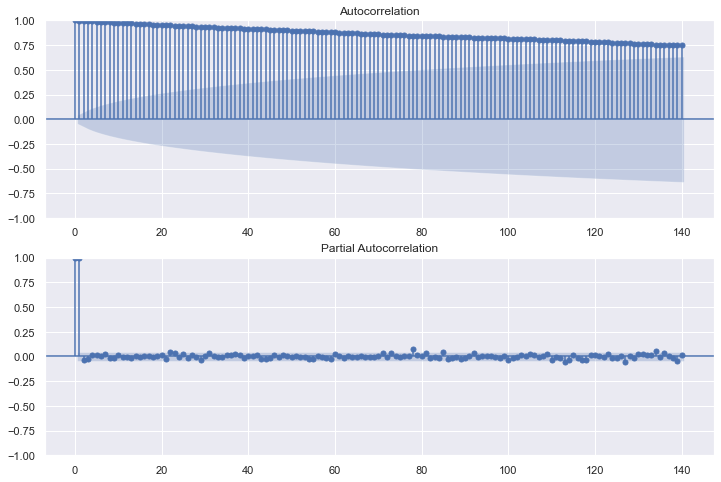

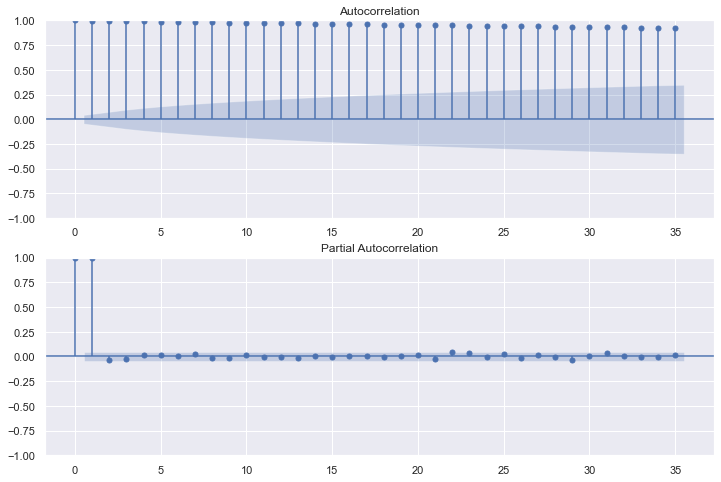

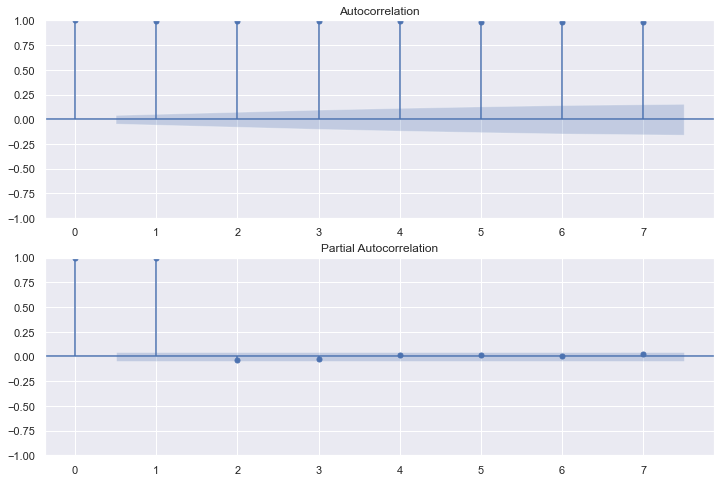


 --------------- facebook ----------------


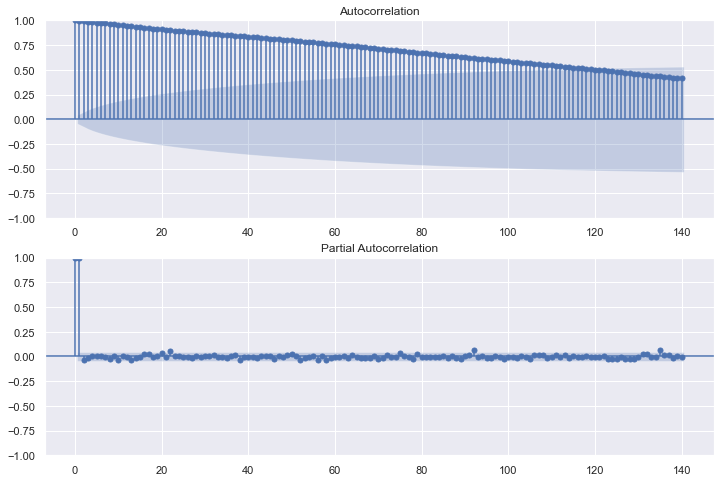

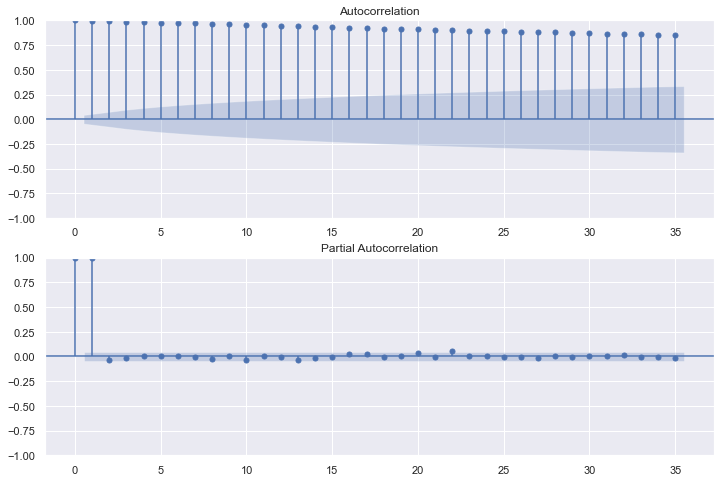

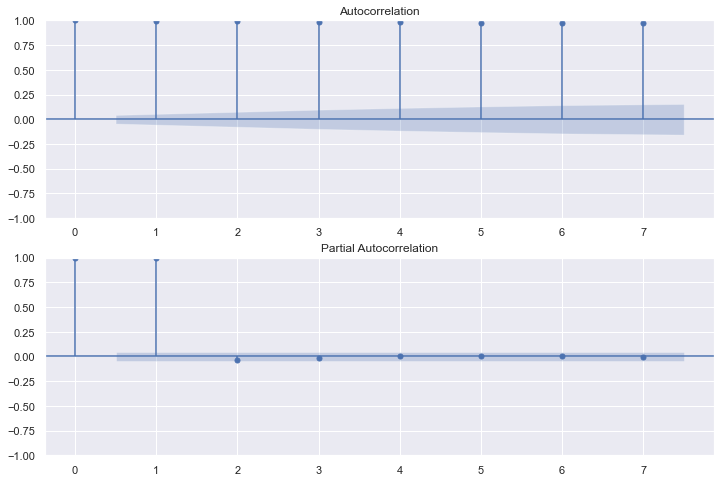


 --------------- amazon ----------------


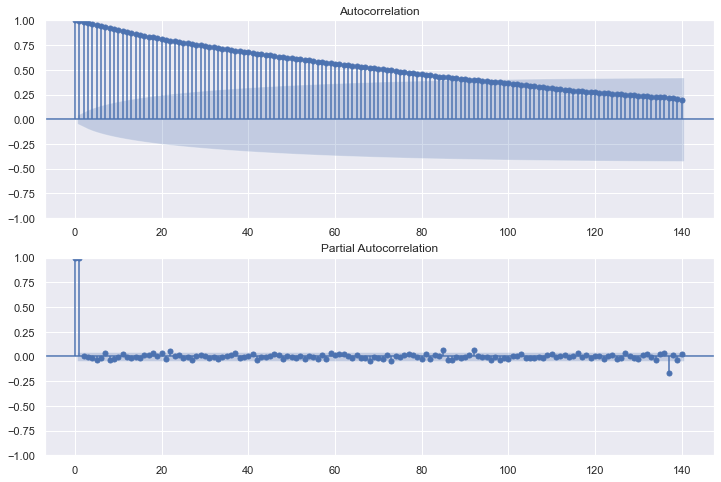

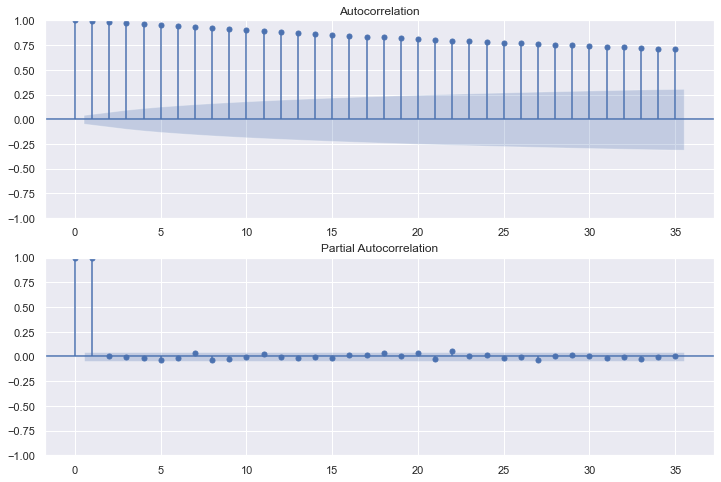

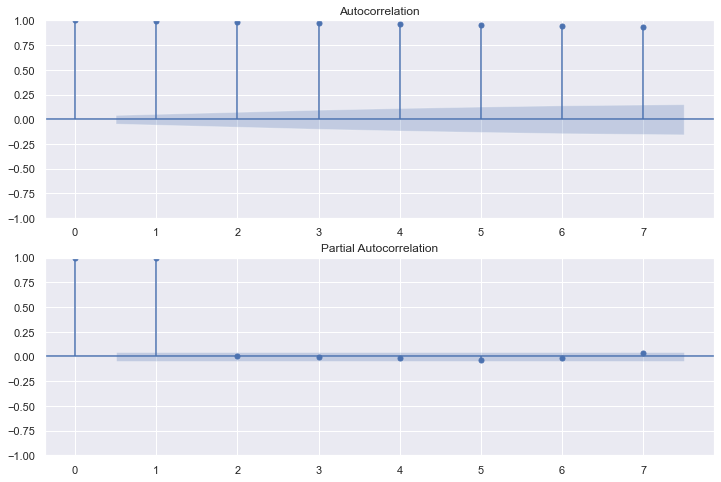


 --------------- total ----------------


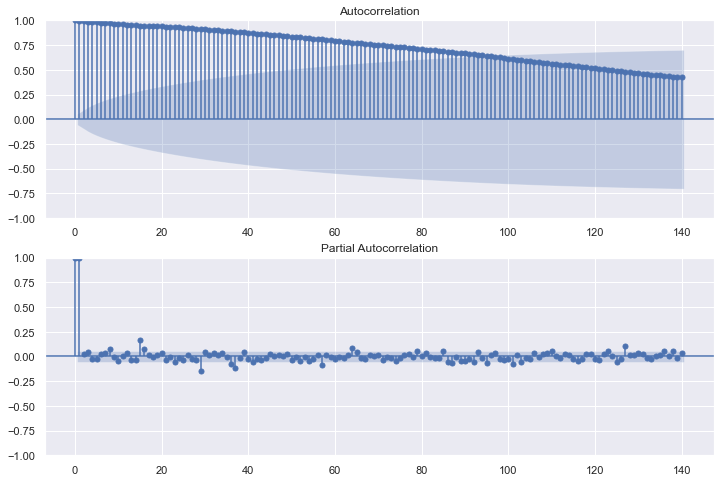

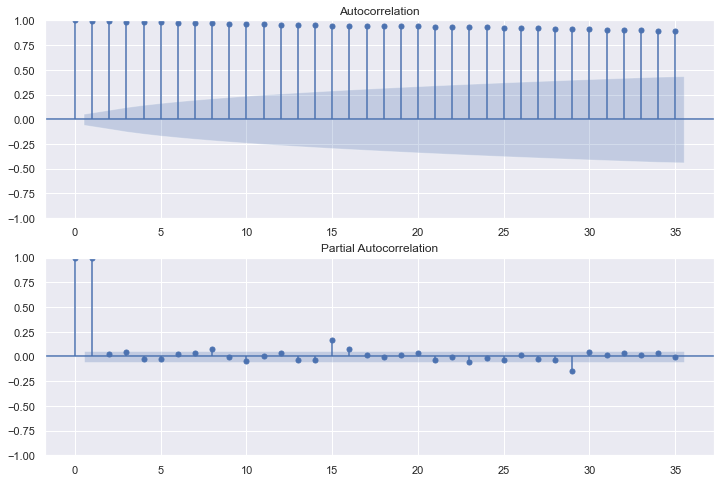

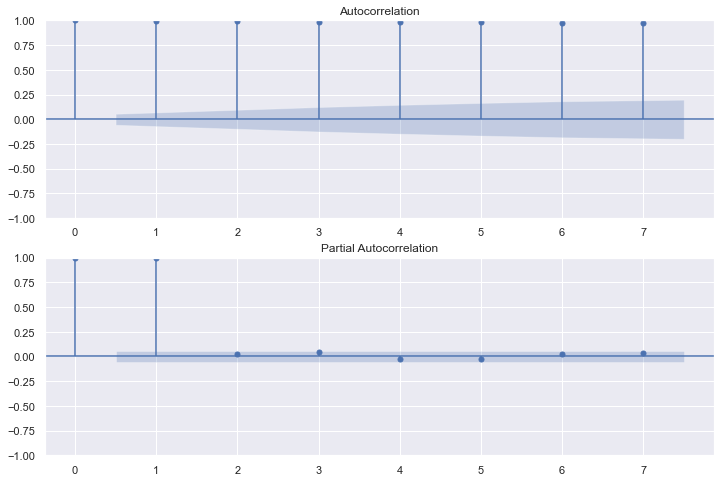


 --------------- gazprom ----------------


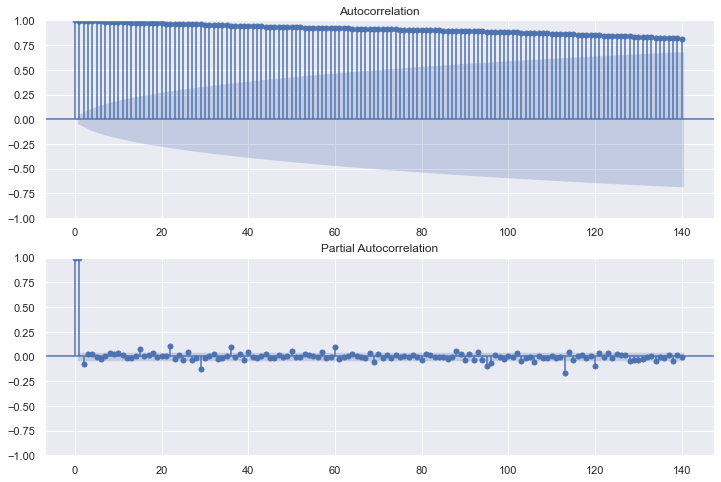

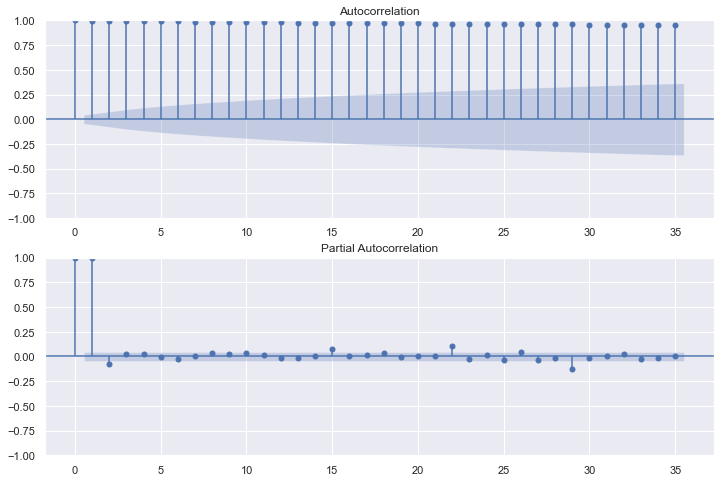

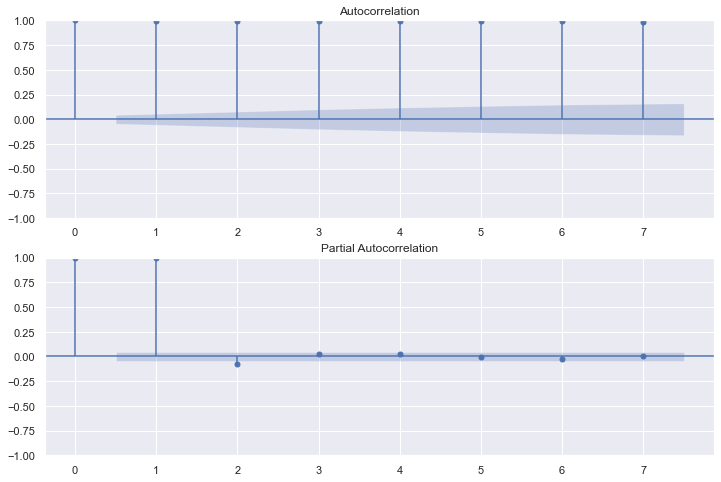


 --------------- alibaba ----------------


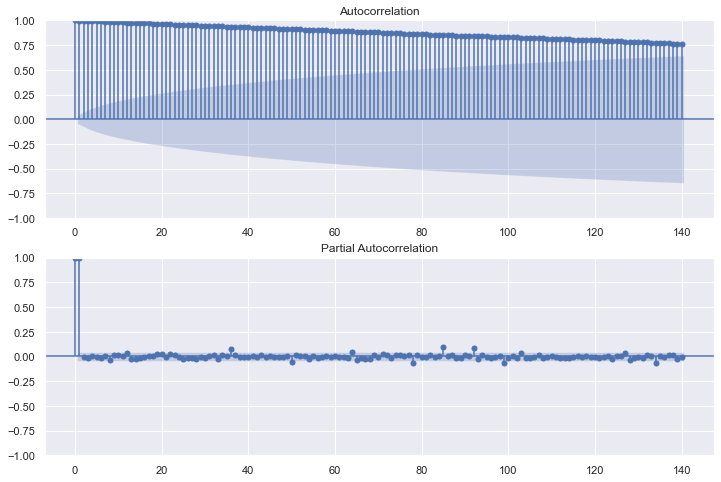

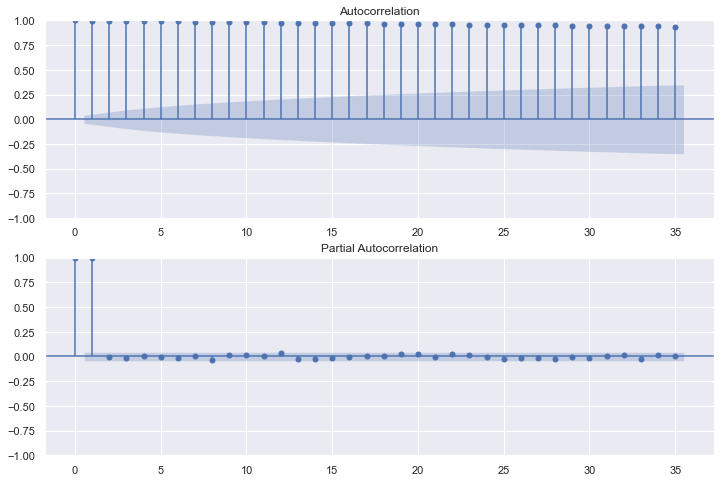

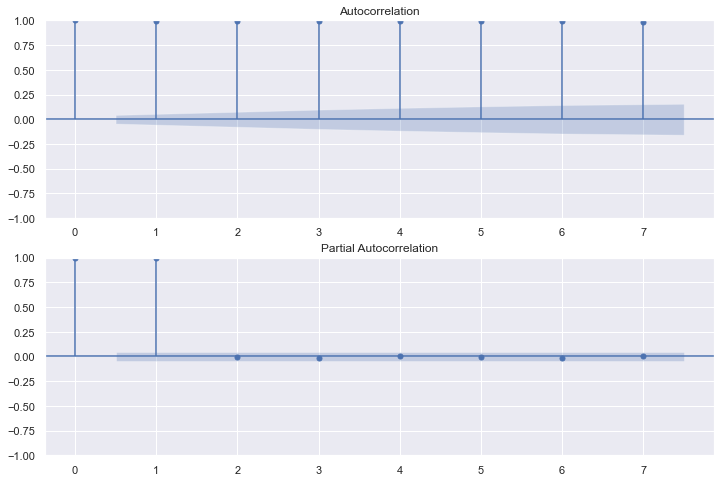


 --------------- bnp_paribas ----------------


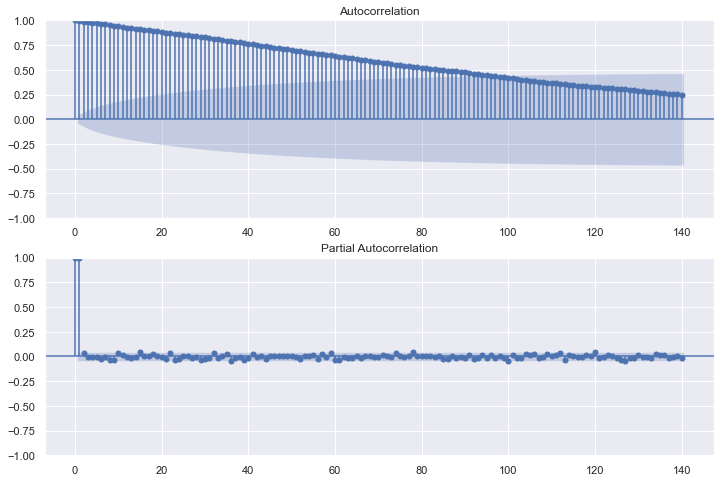

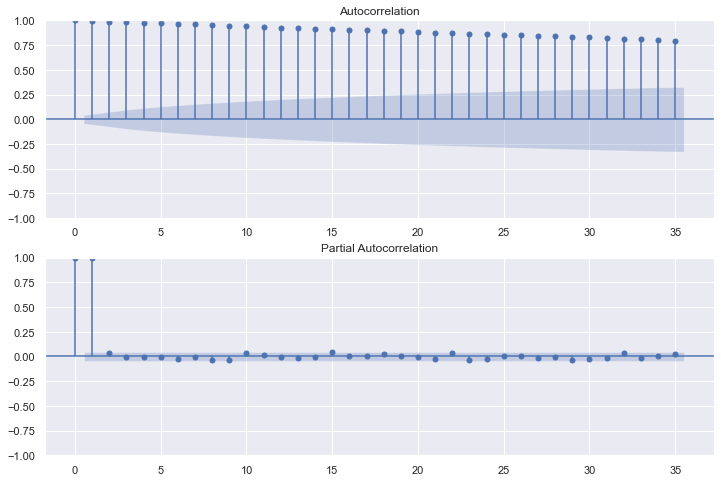

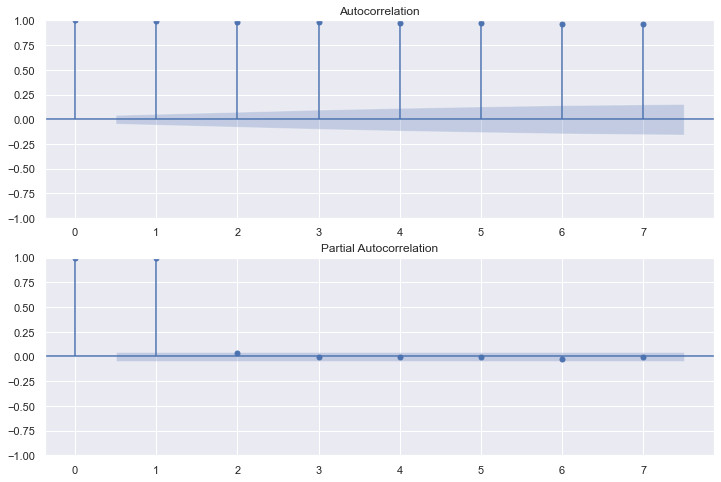


 --------------- BP ----------------


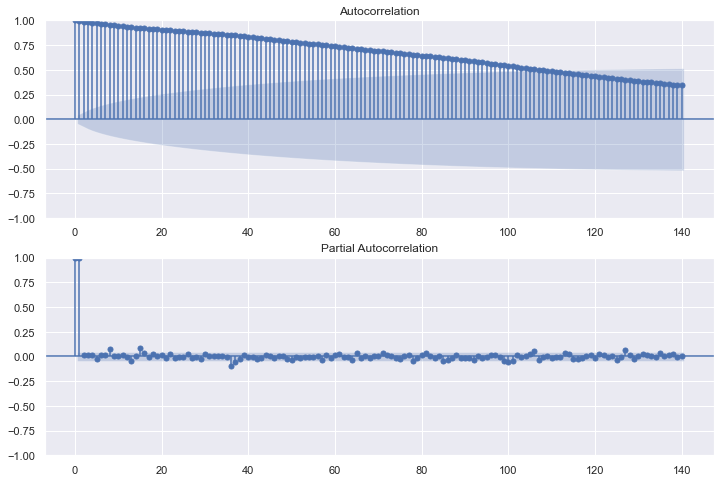

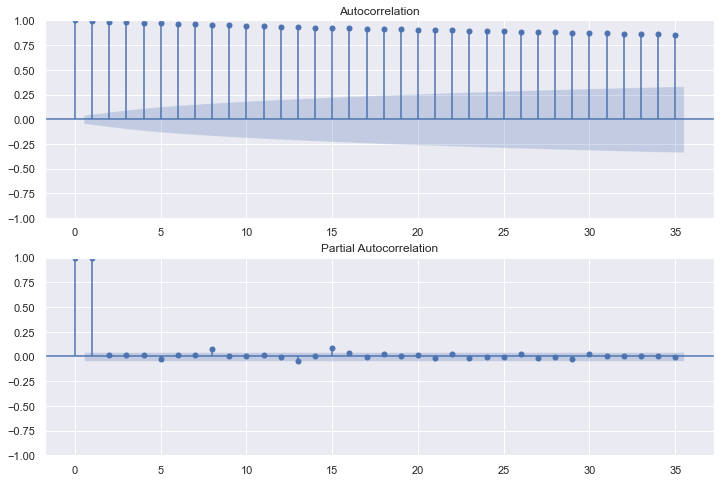

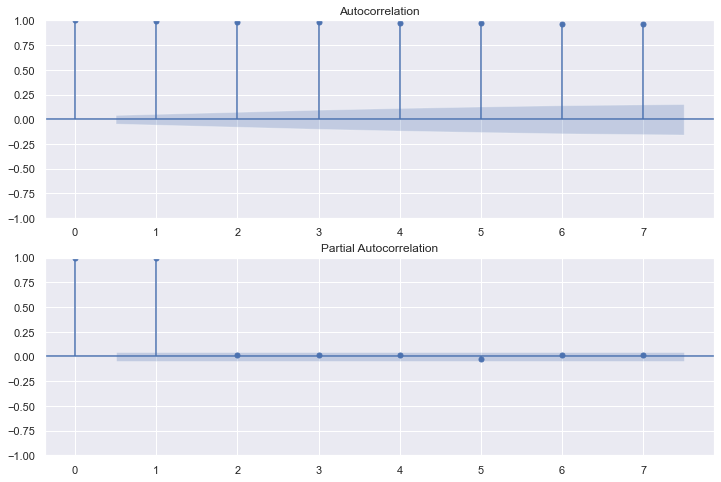


 --------------- ferrari ----------------


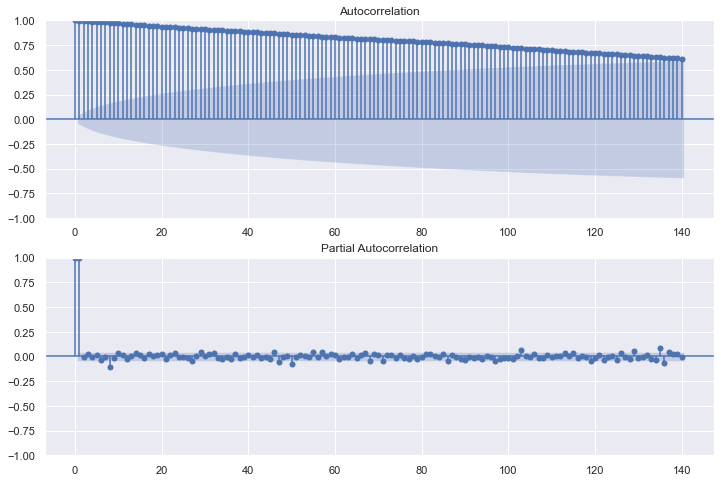

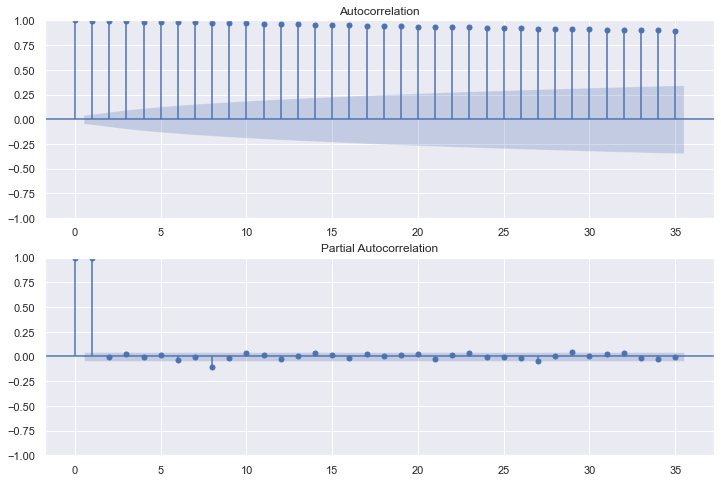

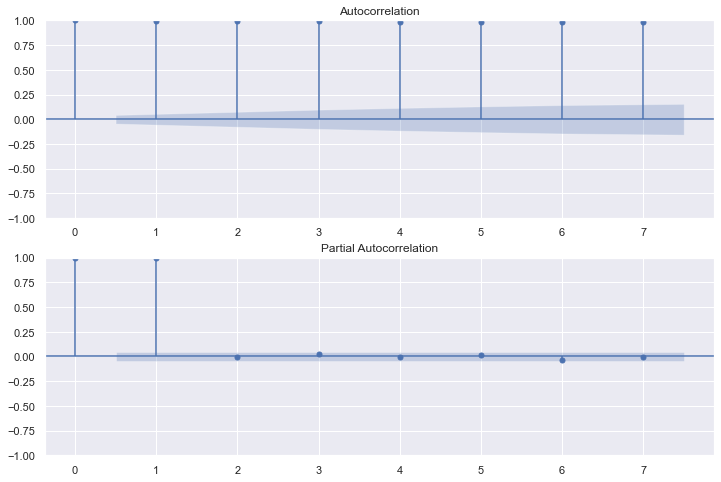

In [65]:
for company in All_the_companies:
    print("\n --------------- {} ----------------".format(company))
    plot_ACF_and_PACF(data_train[company], lags)

<div class="alert alert-block alert-info">
<p><b>COMMENT :</b></p>

<p>The p and q values of an ARMA model can be derived using two tools:</p>

<p>- The autocorrelogram for the parameter q of the MA model (Moving Average Model).</p>

<p>- The partial autocorrelogram for the parameter p of the AR model (Auto-Regressive Model).</p>

<p>For each curve, we consider the smallest value that is significantly outside the confidence interval. We find <b>p = 1 and q = 1.</b></p>

<p><b>CONCLUSION :</b> The time series 'Stock market' can be modeled by an ARMA(1,1) process</p>
</div>

## Batch Machine Learning - Training

In [66]:
# Train the models
Modele_11 = {}

for company in All_the_companies:
        print("\n---------------------- Close price train for {} ----------------------" \
              .format(company))
        temps = perf_counter()

        Modele_11[company] = Modele_ARIMA(data_train[company], 1, 1)

        temps_train_Modele_11 = perf_counter() - temps
        Batch_ML_result["CPU_time"].append(temps_train_Modele_11)
        print("")
        print("+--------------------------+")
        print("| CPU time = {:.3f} seconds |".format(temps_train_Modele_11))
        print("+--------------------------+")


---------------------- Close price train for google ----------------------
                               SARIMAX Results                                
Dep. Variable:      ('GOOG', 'Close')   No. Observations:                 2016
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8389.202
Date:                Thu, 31 Mar 2022   AIC                          16786.404
Time:                        16:41:59   BIC                          16808.840
Sample:                             0   HQIC                         16794.639
                               - 2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2535.3254    373.577      6.787      0.000    1803.128    3267.523
ar.L1          0.9994      0.001   1212.757      0.000 



Box-Pierce test: pvalue = 0.9564415359228409
The residual is a white noise because the hypothesis H0 is satisfied

Shapiro-Wilk test: pvalue = 5.5197146509754544e-42
The residual does not follow a Normal distribution because the hypothesis H0 is not verified

Augmented Dickey Fuller Test: pvalue = 1.4096812398155584e-18
The residual is a stationary process because the hypothesis H0 is not verified

Kwiatkowski-Phillips-Schmidt-Shin test: pvalue = 0.1
The residual is a stationary process because the hypothesis H0 is verified

+--------------------------+
| CPU time = 0.197 seconds |
+--------------------------+

---------------------- Close price train for gazprom ----------------------
                               SARIMAX Results                                
Dep. Variable:     ('OGZPY', 'Close')   No. Observations:                 1898
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2443.442
Date:                Thu, 31 Mar 2022   AIC                       

                               SARIMAX Results                                
Dep. Variable:        ('BP', 'Close')   No. Observations:                 2016
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  20.127
Date:                Thu, 31 Mar 2022   AIC                            -32.254
Time:                        16:42:03   BIC                             -9.818
Sample:                             0   HQIC                           -24.019
                               - 2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.0917      1.054     24.745      0.000      24.025      28.158
ar.L1          0.9965      0.001    678.024      0.000       0.994       0.999
ma.L1         -0.0283      0.028     -0.995      0.3

## Batch Machine Learning - Predict

In [67]:
# predict the close stocks
df_Prediction_11 = {}

for company in All_the_companies:
    MAE, df_Prediction_11[company] = Modele_Predict(Modele_11[company], data_test[company])
    print("\nMean Absolute Error of the prediction = {:.2f} USD".format(MAE))
    Batch_ML_result["MAE"].append(MAE)
    display(df_Prediction_11[company])


Mean Absolute Error of the prediction = 91.89 USD


"(GOOG, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,2676.901026,2646.525707,2707.276346
2022-03-10 11:30:00-05:00,2676.814796,2633.131678,2720.497914
2022-03-10 12:30:00-05:00,2676.728617,2622.946005,2730.511230
2022-03-10 13:30:00-05:00,2676.642492,2614.387169,2738.897815
2022-03-10 14:30:00-05:00,2676.556418,2606.859333,2746.253504
...,...,...,...
2022-03-30 12:30:00-04:00,2669.346899,2377.828363,2960.865436
2022-03-30 13:30:00-04:00,2669.265270,2376.235844,2962.294696
2022-03-30 14:30:00-04:00,2669.183690,2374.652951,2963.714428



Mean Absolute Error of the prediction = 10.99 USD


"(FB, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,198.643005,193.126882,204.159128
2022-03-10 11:30:00-05:00,198.743267,190.747562,206.738972
2022-03-10 12:30:00-05:00,198.843441,188.975493,208.711389
2022-03-10 13:30:00-05:00,198.943528,187.508361,210.378694
2022-03-10 14:30:00-05:00,199.043527,186.233714,211.853339
...,...,...,...
2022-03-30 12:30:00-04:00,207.324243,154.194667,260.453820
2022-03-30 13:30:00-04:00,207.416913,154.018658,260.815168
2022-03-30 14:30:00-04:00,207.509502,153.844379,261.174625



Mean Absolute Error of the prediction = 236.54 USD


"(AMZN, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,2787.830906,2743.436224,2832.225588
2022-03-10 11:30:00-05:00,2790.839581,2728.404286,2853.274875
2022-03-10 12:30:00-05:00,2793.830821,2717.652261,2870.009382
2022-03-10 13:30:00-05:00,2796.804729,2709.133945,2884.475512
2022-03-10 14:30:00-05:00,2799.761403,2702.050605,2897.472201
...,...,...,...
2022-03-30 12:30:00-04:00,2999.297659,2667.395347,3331.199970
2022-03-30 13:30:00-04:00,3001.080953,2668.160205,3334.001700
2022-03-30 14:30:00-04:00,3002.853913,2668.929551,3336.778275



Mean Absolute Error of the prediction = 0.84 USD


"(TTE, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,50.707743,49.939371,51.476116
2022-03-10 11:30:00-05:00,50.700330,49.631423,51.769236
2022-03-10 12:30:00-05:00,50.692943,49.392708,51.993179
2022-03-10 13:30:00-05:00,50.685584,49.190734,52.180435
2022-03-10 14:30:00-05:00,50.678253,49.012572,52.343934
...,...,...,...
2022-03-30 12:30:00-04:00,50.134814,44.037744,56.231883
2022-03-30 13:30:00-04:00,50.129538,44.009586,56.249491
2022-03-30 14:30:00-04:00,50.124282,43.981702,56.266863



Mean Absolute Error of the prediction = 2.71 USD


"(OGZPY, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-02-10 10:30:00-05:00,8.927756,8.797079,9.058433
2022-02-10 11:30:00-05:00,8.925940,8.734902,9.116978
2022-02-10 12:30:00-05:00,8.924127,8.687789,9.160464
2022-02-10 13:30:00-05:00,8.922316,8.648168,9.196464
2022-02-10 14:30:00-05:00,8.920508,8.613262,9.227754
...,...,...,...
2022-03-02 13:30:00-05:00,8.786004,7.584235,9.987773
2022-03-02 14:30:00-05:00,8.784402,7.576367,9.992437
2022-03-02 15:30:00-05:00,8.782803,7.568553,9.997053



Mean Absolute Error of the prediction = 12.10 USD


"(BABA, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,100.921758,97.273112,104.570404
2022-03-10 11:30:00-05:00,100.929057,95.771207,106.086908
2022-03-10 12:30:00-05:00,100.936356,94.620345,107.252368
2022-03-10 13:30:00-05:00,100.943655,93.651306,108.236004
2022-03-10 14:30:00-05:00,100.950952,92.798500,109.103405
...,...,...,...
2022-03-30 12:30:00-04:00,101.583521,66.745212,136.421830
2022-03-30 13:30:00-04:00,101.590765,66.565095,136.616436
2022-03-30 14:30:00-04:00,101.598009,66.386005,136.810013



Mean Absolute Error of the prediction = 0.81 USD


"(BNPQY, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 09:30:00-05:00,28.297984,27.792693,28.803275
2022-03-10 10:30:00-05:00,28.306706,27.602064,29.011349
2022-03-10 11:30:00-05:00,28.315398,27.457483,29.173312
2022-03-10 12:30:00-05:00,28.324058,27.337235,29.310881
2022-03-10 13:30:00-05:00,28.332688,27.232715,29.432661
...,...,...,...
2022-03-30 12:30:00-04:00,28.977498,24.917696,33.037300
2022-03-30 13:30:00-04:00,28.983813,24.908469,33.059156
2022-03-30 14:30:00-04:00,28.990105,24.899388,33.080822



Mean Absolute Error of the prediction = 1.17 USD


"(BP, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,29.014036,28.545076,29.482997
2022-03-10 11:30:00-05:00,29.003689,28.350960,29.656417
2022-03-10 12:30:00-05:00,28.993377,28.199193,29.787562
2022-03-10 13:30:00-05:00,28.983103,28.069891,29.896314
2022-03-10 14:30:00-05:00,28.972864,27.955149,29.990580
...,...,...,...
2022-03-30 12:30:00-04:00,28.207826,24.454284,31.961367
2022-03-30 13:30:00-04:00,28.200333,24.432421,31.968244
2022-03-30 14:30:00-04:00,28.192866,24.410740,31.974992



Mean Absolute Error of the prediction = 9.63 USD


"(RACE, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-10 10:30:00-05:00,197.809848,194.966906,200.652789
2022-03-10 11:30:00-05:00,197.861190,193.818558,201.903822
2022-03-10 12:30:00-05:00,197.912413,192.956138,202.868687
2022-03-10 13:30:00-05:00,197.963514,192.240940,203.686089
2022-03-10 14:30:00-05:00,198.014496,191.619760,204.409232
...,...,...,...
2022-03-30 12:30:00-04:00,202.020806,177.100308,226.941304
2022-03-30 13:30:00-04:00,202.062256,177.033971,227.090541
2022-03-30 14:30:00-04:00,202.103608,176.968501,227.238716


## Plot the ARMA results

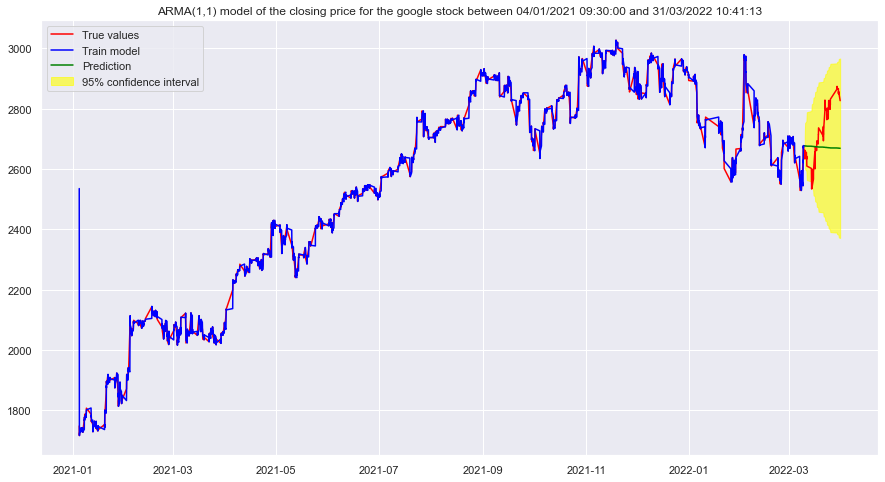

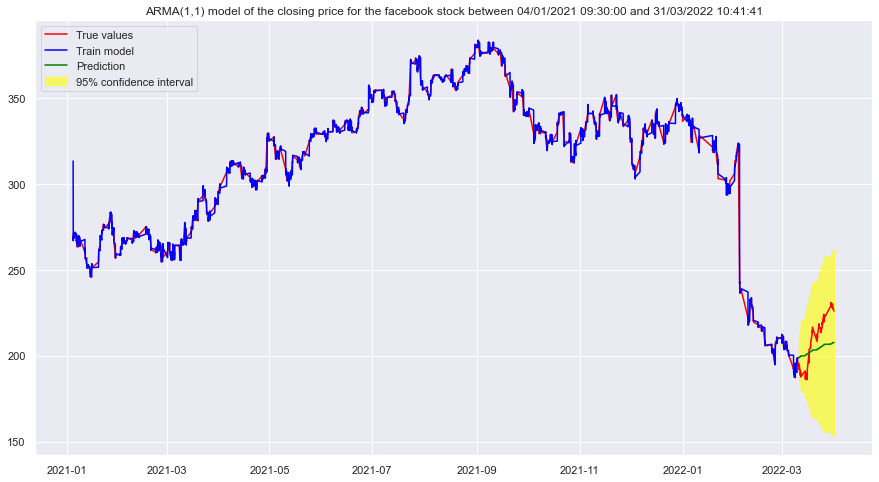

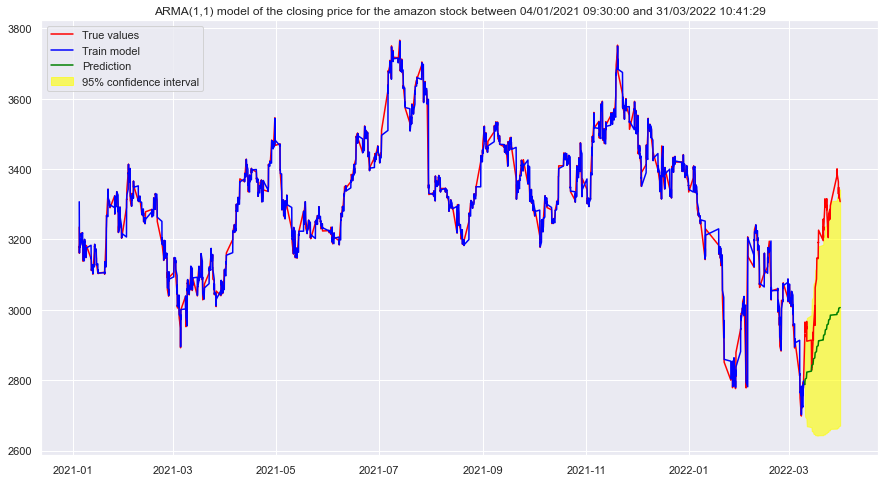

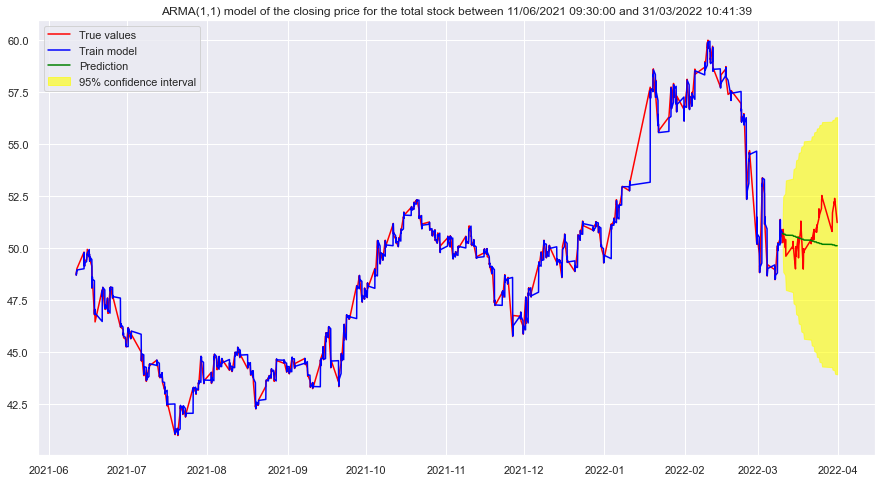

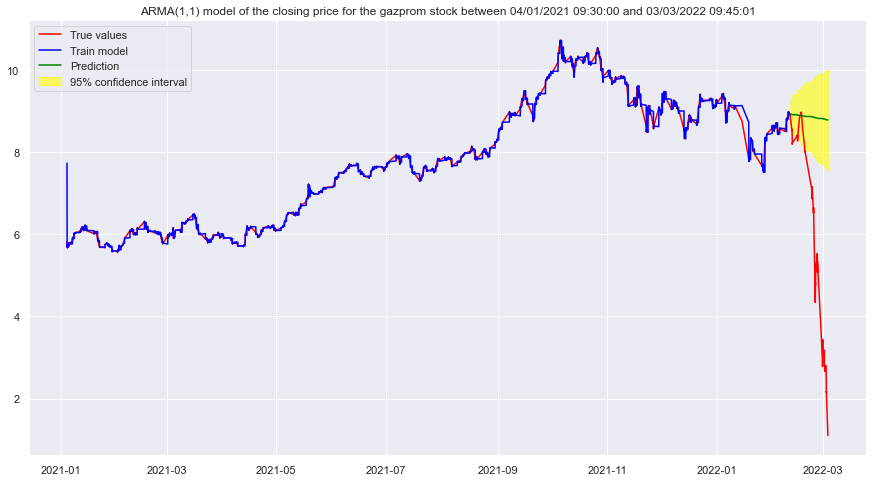

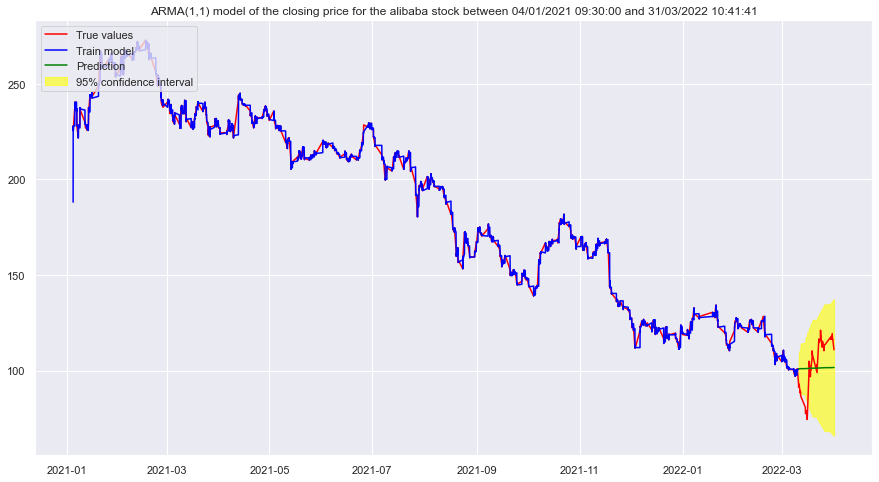

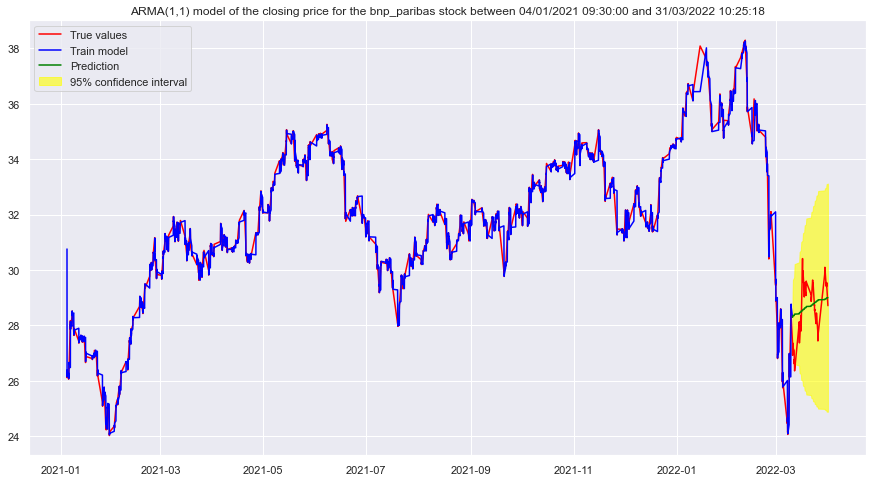

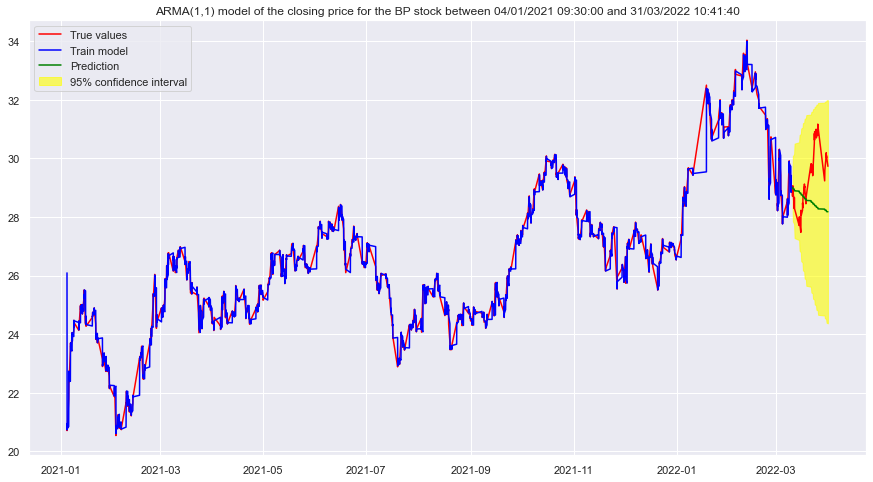

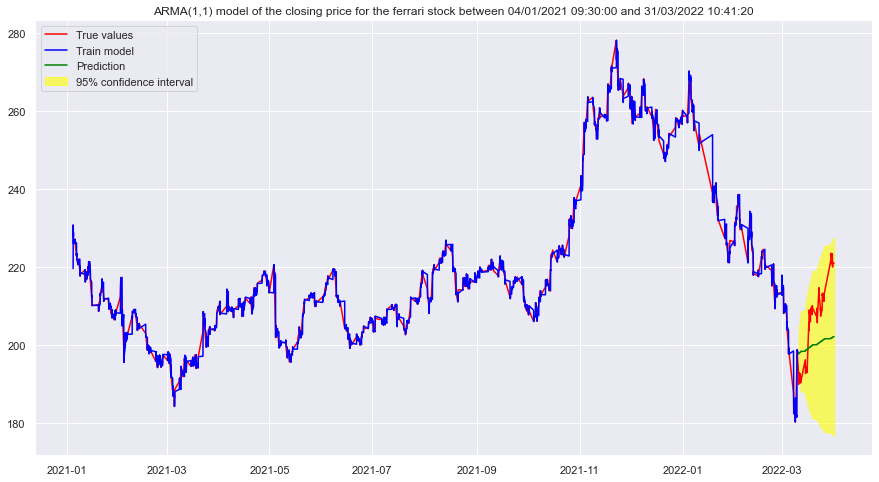

In [68]:
# Plot the ARMA results
for company in All_the_companies:
    plot_predict_ARMA(company, data_clean[company], Modele_11[company], df_Prediction_11[company])

## The performance indicators of the ARMA model are put into a dataframe and stored in csv format. 

__They will be used in the comparison between Batch Machine Learning and On-Line Machine Learning__

In [69]:
for company in All_the_companies:
    Batch_ML_result["date"].append(int(time.time()) * 1000)
    Batch_ML_result["Regression"].append("Batch")
    Batch_ML_result["Company"].append(company)

df_Batch_ML_result = pd.DataFrame(Batch_ML_result)
df_Batch_ML_result

,CPU_time,MAE,date,Regression,Company
0,0.540068,91.887048,1648737726000,Batch,google
1,0.197319,10.993366,1648737726000,Batch,facebook
2,0.402055,236.544306,1648737726000,Batch,amazon
3,0.196773,0.836845,1648737726000,Batch,total
4,0.478310,2.713047,1648737726000,Batch,gazprom
5,0.208008,12.096017,1648737726000,Batch,alibaba
6,1.347959,0.806176,1648737726000,Batch,bnp_paribas
7,0.728823,1.167470,1648737726000,Batch,BP
8,0.164173,9.629661,1648737726000,Batch,ferrari


In [70]:
df_Batch_ML_result.to_csv("ARMA_performance.csv", sep=";", decimal=",")

# Processing of stock market data in Kafka

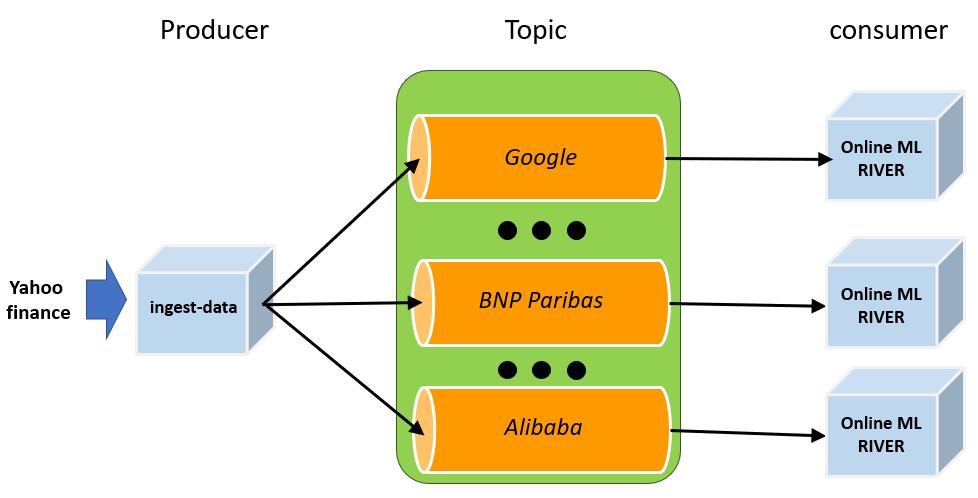

__We create a Kafka topic for each company and stream the stock data retrieved with yfinance into these topics.__

__In another notebook, we will retrieve this stock market data to apply a Machine Learning model with RIVER.__

__In the last notebook, we plot the prediction results from the data stored in the Kafka predicts topics__

## Notebook settings

In [71]:
trace_ingest_data = True
Nb_to_print = 500
pp = pprint.PrettyPrinter()

## Creation of topics if needed

In [72]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id="Project_DataStream")

topic_name = {}
topic_predict_name = {}

for company in All_the_companies:
    topic_name[company] = company
    topic_predict_name[company] = "predict__{}".format(company)

    # The stock data
    if topic_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

    # The predict results
    if topic_predict_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_predict_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

## Kafka Producer : ingest_data

In [73]:
if trace_ingest_data:
    print("-----  INGEST DATA FROM YAHOO FINANCE  ----")

producer = KafkaProducer(bootstrap_servers="localhost:9092")

Nb_items = {}
for company in All_the_companies:
    Nb_items[company] = 0

try:
    for date, col in data.iterrows():        
        ligne = {}
        for company in All_the_companies:
            ligne[tick[company]] = {}
            ligne[tick[company]]["date"] = int(datetime.timestamp(date))*1000

        for indice in col.index:
            ligne[indice[0]][indice[1]] = col[indice]

        for company in All_the_companies:
            if not math.isnan(ligne[tick[company]]["Open"]):
                Nb_items[company] += 1
                producer.send(topic_name[company], json.dumps(ligne[tick[company]]).encode())
            
                if Nb_items[company] == 1:
                    if trace_ingest_data:
                        print("---------- {} ----------".format(company))
                        pp.pprint(ligne[tick[company]])
                        print("")

                if Nb_items[company] % Nb_to_print == 0:
                    if trace_ingest_data:
                        print("{} - {} records sent to the Kafka topic {}" \
                              .format(time.strftime("%d/%m/%Y %H:%M:%S"),
                                      Nb_items[company],
                                      company))

except KeyboardInterrupt:
    if trace_ingest_data:
        print ("----------  END OF INGEST DATA  ----------")
except Exception as e:
    print("An arror has occurred")
    print(e)

-----  INGEST DATA FROM YAHOO FINANCE  ----
---------- google ----------
{'Adj Close': 1748.239990234375,
 'Close': 1748.239990234375,
 'High': 1760.6400146484375,
 'Low': 1740.949951171875,
 'Open': 1758.4200439453125,
 'Volume': 241052.0,
 'date': 1609770600000}

---------- facebook ----------
{'Adj Close': 271.1700134277344,
 'Close': 271.1700134277344,
 'High': 273.8999938964844,
 'Low': 269.9800109863281,
 'Open': 273.75,
 'Volume': 2708653.0,
 'date': 1609770600000}

---------- amazon ----------
{'Adj Close': 3235.080078125,
 'Close': 3235.080078125,
 'High': 3271.175048828125,
 'Low': 3217.0,
 'Open': 3271.03125,
 'Volume': 817344.0,
 'date': 1609770600000}

---------- gazprom ----------
{'Adj Close': 5.820000171661377,
 'Close': 5.820000171661377,
 'High': 5.829999923706055,
 'Low': 5.800000190734863,
 'Open': 5.809999942779541,
 'Volume': 0.0,
 'date': 1609770600000}

---------- alibaba ----------
{'Adj Close': 227.75,
 'Close': 227.75,
 'High': 230.3800048828125,
 'Low': 225.